In [1]:
import sys

import seaborn
from tensorflow.keras import datasets, layers, models, losses
import numpy as np
from PIL import Image
import tensorflow as tf
import torchvision as tv
import matplotlib.pyplot as plt
from livelossplot import PlotLossesKeras
import tensorflow_addons as tfa
from sklearn.metrics import confusion_matrix

sys.path.append('../../')

from core.datasets import get_ds, open_f
from core.make_answer import make_ans_file 
from core.ensembles import get_bagging_pred, print_bagging_ensemble_statistic, print_models_statistic, get_ensemble_modelbase, get_modeset, get_raw_bagging_pred


C:\Users\Salam\AppData\Roaming\Python\Python310\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [2]:
transformer = tv.transforms.Compose([
    tv.transforms.ColorJitter(brightness=.2, hue=0.2, contrast=0.5),
    tv.transforms.RandomAffine(degrees=(-10, 10), translate=(0, 0.1), scale=(0.85, 1)),
    tv.transforms.RandomPerspective(distortion_scale=0.2, p=0.7),
])

In [3]:
acc_test_ds = open_f("smote_data_train_5000", back=2)

In [4]:
acc_test_ds_y = acc_test_ds["labels"]
acc_test_ds_x = acc_test_ds["images"] / 255.

In [5]:
train_ds, val_ds, test_ds = get_ds('repaired_data_train', 'repaired_data_test', transform=transformer, one_hot=True, back=2)
val_ds_x = np.array([i[0] for i in val_ds.unbatch().as_numpy_iterator()])
val_ds_y = np.array([i[1] for i in val_ds.unbatch().as_numpy_iterator()])
val_ds_y = np.argmax(val_ds_y, axis=1)

In [7]:
model_1 = tf.keras.models.load_model(f'../checkpoints/model_g_1_categorical_accuracy.h5')
model_3 = tf.keras.models.load_model(f'../checkpoints/model_g_3_avg_categorical_accuracy.h5')
model_smote = tf.keras.models.load_model(f'../checkpoints/model_s_smote_avg_categorical_accuracy.h5')
model_c = tf.keras.models.load_model(f'../checkpoints/model_C_EN_1_categorical_accuracy.h5')
model_8 = tf.keras.models.load_model(f'../checkpoints/model_g_8_avg_categorical_accuracy.h5')
model_36h_griganet = tf.keras.models.load_model(f'../checkpoints/model_g_11_avg_categorical_accuracy.h5')
model_16 = tf.keras.models.load_model(f'../checkpoints/model_g_16_avg_categorical_accuracy.h5')
model_17 = tf.keras.models.load_model(f'../checkpoints/model_g_17_avg_categorical_accuracy.h5')

In [8]:
ova_0 = tf.keras.models.load_model(f'../checkpoints/model_zero_avg_categorical_accuracy.h5')
ova_1 = tf.keras.models.load_model(f'../checkpoints/model_one_avg_categorical_accuracy.h5')
ova_2 = tf.keras.models.load_model(f'../checkpoints/model_two_avg_categorical_accuracy.h5')
ova_3 = tf.keras.models.load_model(f'../checkpoints/model_three_avg_categorical_accuracy.h5')
ova_4 = tf.keras.models.load_model(f'../checkpoints/model_four_avg_categorical_accuracy.h5')
ova_5 = tf.keras.models.load_model(f'../checkpoints/model_five_avg_categorical_accuracy.h5')
ova_6 = tf.keras.models.load_model(f'../checkpoints/model_six_avg_categorical_accuracy.h5')
ova_7 = tf.keras.models.load_model(f'../checkpoints/model_seven_avg_categorical_accuracy.h5')
ova_8 = tf.keras.models.load_model(f'../checkpoints/model_eight_avg_categorical_accuracy.h5')
ova_9 = tf.keras.models.load_model(f'../checkpoints/model_nine_avg_categorical_accuracy.h5')

ova = {0:ova_0, 1:ova_1, 2:ova_2, 3:ova_3, 4:ova_4, 5:ova_5,  6:ova_6, 7:ova_7, 8:ova_8, 9:ova_9}

In [9]:
models = [model_1, model_smote, model_8, model_c, model_36h_griganet, model_16, model_17]
names = ["model G1", "model SMOTE", "model G8", "model C1", "model G11", "model G16", "model G17"]

modelbase = get_ensemble_modelbase(models=models, names=names, x_val=acc_test_ds_x)

1563/1563 [==============================] - 18s 11ms/step


In [10]:
print_models_statistic(modelbase=modelbase, y_val=acc_test_ds_y)

SCORE
model G1: accuracy: 0.97812 f1_score: 0.9781390642763794
model SMOTE: accuracy: 0.99408 f1_score: 0.9940810122351309
model G8: accuracy: 0.98988 f1_score: 0.9898771132231688
model C1: accuracy: 0.9719 f1_score: 0.9719381931043831
model G11: accuracy: 0.99618 f1_score: 0.9961804763364667
model G16: accuracy: 0.93674 f1_score: 0.9366979284539843
model G17: accuracy: 0.99096 f1_score: 0.9909604934305734


In [11]:
selected_names = ["model SMOTE", "model G8",  "model C1", "model G11", "model G17"]
modelset = get_modeset(modelbase, selected_names)

In [12]:
y_test_acc_pred = print_bagging_ensemble_statistic(modelset=modelset, y_val=acc_test_ds_y)

SCORE

ensemble accuracy: 0.99732

ensemble f1_score: 0.9973199917994016


In [13]:
def min_max_scaler(x):
    min_x = min(x)
    max_x = max(x)
    result = []
    for i in x:
        result.append((i - min_x)/(max_x-min_x))
    return np.array(result)

# Получить первый/второй/третий по страшинству предикт. (максимальные логиты).
def get_ordinal_pred(y_logits, i):
    work = list(y_logits.copy())
    work.sort(reverse=True)
    return list(y_logits).index(work[i])

---
* Тесты на трейновом датасете

In [14]:
ova_preds = {}
for i in range(10):
    ova_preds[i] = ova[i].predict(acc_test_ds_x, verbose=True)

final_ova_preds = np.full((len(acc_test_ds_x), 10), 0.)
for i in range(len(acc_test_ds_y)):
    l = np.zeros(10)
    for j in range(10):
        l[j] = ova_preds[j][i]
    final_ova_preds[i] = min_max_scaler(l)

final_ova_preds_without_scaler = np.full((len(acc_test_ds_x), 10), 0.)
for i in range(len(acc_test_ds_y)):
    l = np.zeros(10)
    for j in range(10):
        l[j] = ova_preds[j][i]
    final_ova_preds_without_scaler[i] = l.copy()

1563/1563 [==============================] - 69s 44ms/step


In [18]:
# ALPHA HYBRID TEST (TREE) 
# Имеет 0.96 на кегле

raw_pred = np.full((len(acc_test_ds_x), 10), 0.)
for model in modelset:
    raw_pred += model[1]

changes_count = 0
undo_count = 0
cooked_pred = []
for i in range(len(raw_pred)):
    raw_y = raw_pred[i]
    raw_x = np.expand_dims(acc_test_ds_x[i], 0)
    first_y_pred = get_ordinal_pred(raw_y, 0)
    if ova_preds[first_y_pred][i] >= 0:
        cooked_pred.append(first_y_pred)
        continue
    changes_count += 1

    second_y_pred = get_ordinal_pred(raw_y, 1)
    if ova_preds[second_y_pred][i] >= 0:
        cooked_pred.append(second_y_pred)
        continue

    third_y_pred = get_ordinal_pred(raw_y, 2)
    if ova_preds[third_y_pred][i] >= 0:
        cooked_pred.append(third_y_pred)
        continue

    changes_count-=1
    undo_count +=1
    cooked_pred.append(first_y_pred)
print(f"TOTAL: {changes_count} changes, {undo_count} undo")
cooked_pred = np.array(cooked_pred)
print("ACCURACY SCORE OLD:", np.sum(np.array([np.argmax(k) for k in raw_pred]) == acc_test_ds_y) / len(acc_test_ds_y))
print("ACCURACY SCORE NEW:", np.sum(cooked_pred == acc_test_ds_y) / len(acc_test_ds_y))

TOTAL: 56 changes, 56 undo
ACCURACY SCORE OLD: 0.99732
ACCURACY SCORE NEW: 0.99818


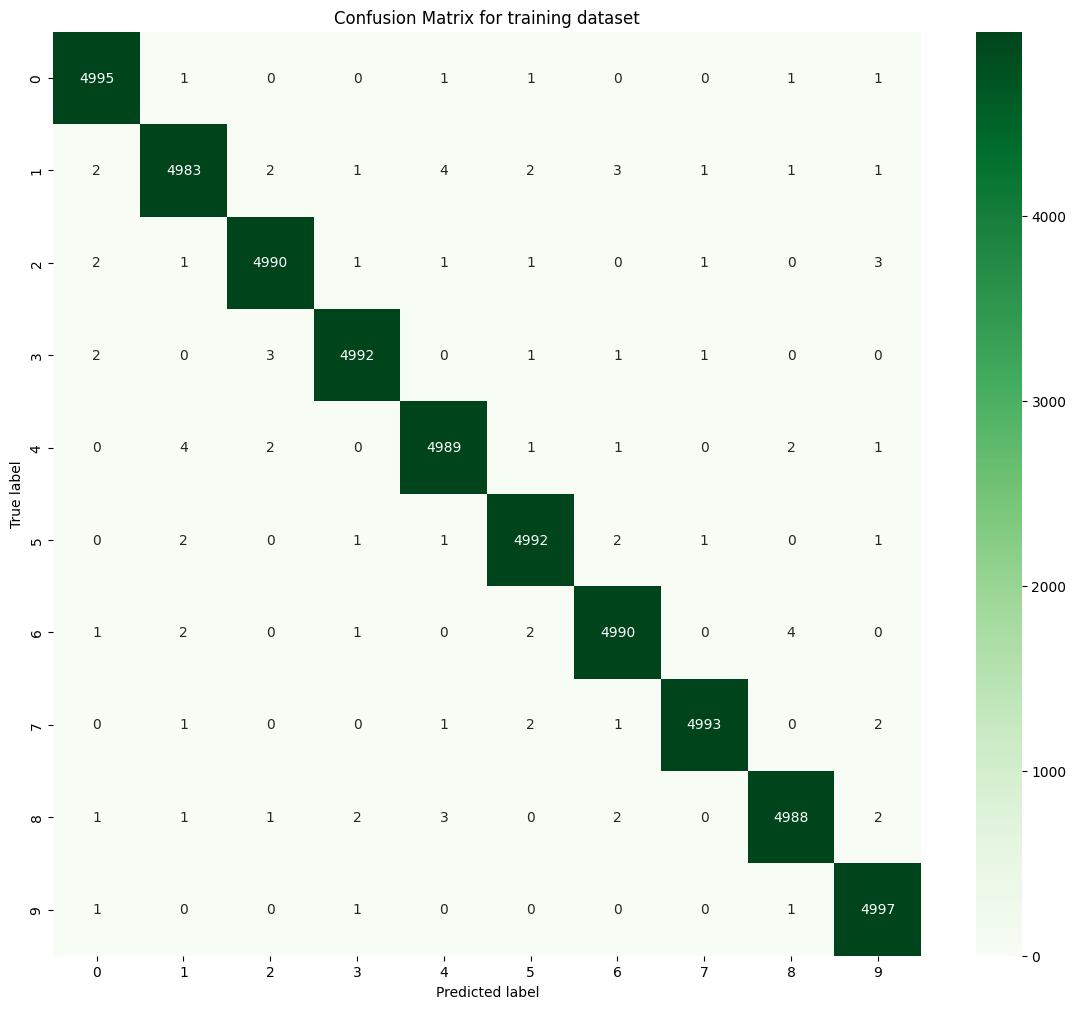

In [19]:
matrix = confusion_matrix(acc_test_ds_y, cooked_pred)

fig, ax = plt.subplots(figsize=(14, 12))
seaborn.heatmap(matrix, annot=True, cmap='Greens', fmt='d', ax=ax)
plt.title('Confusion Matrix for training dataset')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

In [20]:
# BETA HYBRID TEST (NOT TREE)
# 0.961 на кегле

raw_pred = np.full((len(acc_test_ds_x), 10), 0.)
for model in modelset:
    raw_pred += model[1]

nothing_changed = 0
cooked_pred = []
for i in range(len(raw_pred)):
    if np.argmax(raw_pred[i]) == np.argmax(final_ova_preds[i]):
        cooked_pred.append(np.argmax(raw_pred[i]))
        nothing_changed+=1
        continue
    raw_y = raw_pred[i]
    w = final_ova_preds[i] * raw_y
    cooked_pred.append(np.argmax(w))

changed_count = np.sum(cooked_pred != np.array([np.argmax(k) for k in raw_pred]))
tried_to_change = len(acc_test_ds_x) - nothing_changed - changed_count
print(f"TOTAL: {changed_count} changes, {tried_to_change} try change, {nothing_changed} not changed")
cooked_pred = np.array(cooked_pred)
print("ACCURACY SCORE OLD:", np.sum(np.array([np.argmax(k) for k in raw_pred]) == acc_test_ds_y) / len(acc_test_ds_y))
print("ACCURACY SCORE NEW:", np.sum(cooked_pred == acc_test_ds_y) / len(acc_test_ds_y))

TOTAL: 38 changes, 175 try change, 49787 not changed
ACCURACY SCORE OLD: 0.99732
ACCURACY SCORE NEW: 0.99778


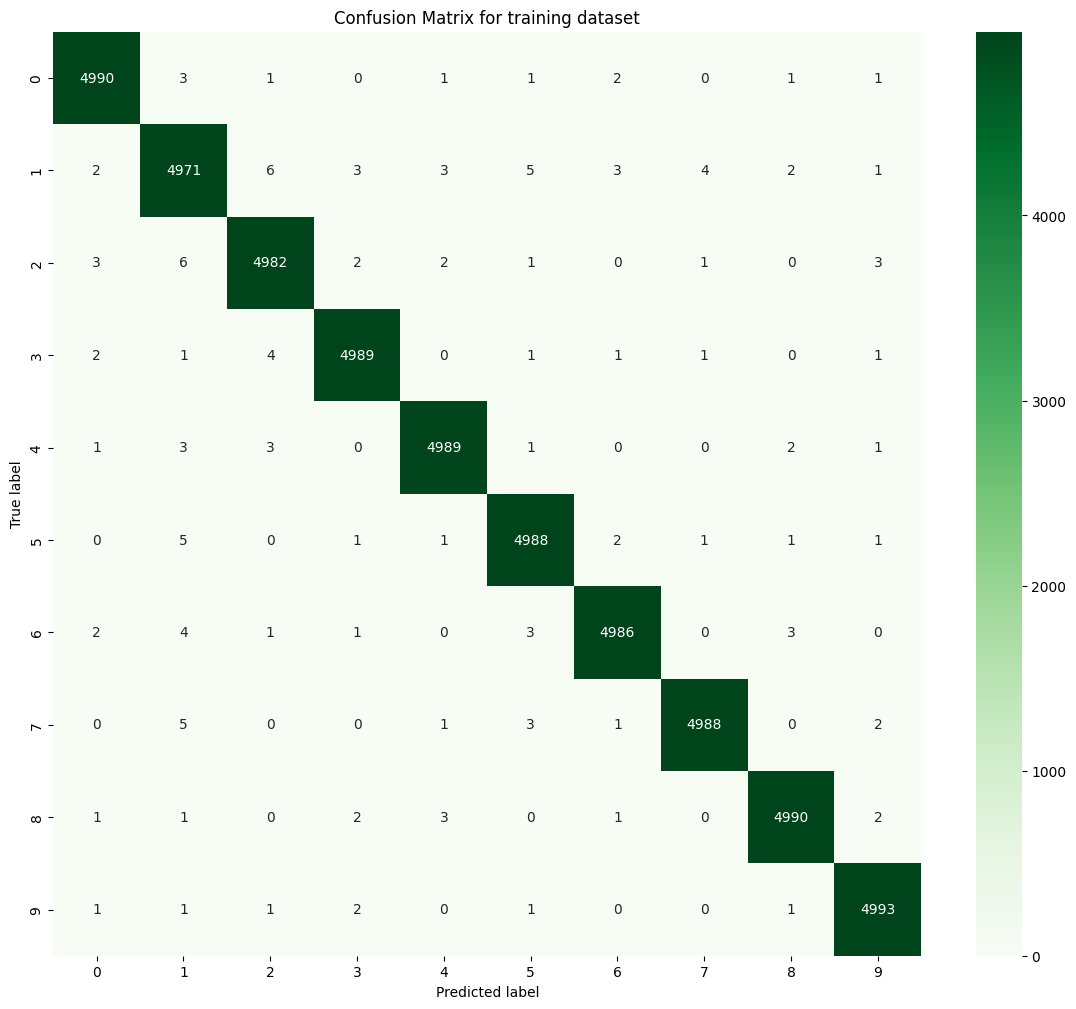

In [21]:
matrix = confusion_matrix(acc_test_ds_y, y_test_acc_pred)

fig, ax = plt.subplots(figsize=(14, 12))
seaborn.heatmap(matrix, annot=True, cmap='Greens', fmt='d', ax=ax)
plt.title('Confusion Matrix for training dataset')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

делаем тестовый предикт и сохраняем:

In [23]:
raw_pred_test = get_raw_bagging_pred(modelset=modelset, x_val=test_ds)

782/782 [==============================] - 10s 13ms/step


In [24]:
ova_test_preds = {}
for i in range(10):
    ova_test_preds[i] = ova[i].predict(test_ds, verbose=True)

final_ova_test_preds = np.full((len(test_ds), 10), 0.)
for i in range(len(test_ds)):
    l = np.zeros(10)
    for j in range(10):
        l[j] = ova_test_preds[j][i]
    final_ova_test_preds[i] = min_max_scaler(l)

final_ova_test_preds_witout_scaler= np.full((len(test_ds), 10), 0.)
for i in range(len(test_ds)):
    l = np.zeros(10)
    for j in range(10):
        l[j] = ova_test_preds[j][i]
    final_ova_test_preds_witout_scaler[i] = l.copy()

782/782 [==============================] - 35s 44ms/step


In [36]:
# ALPHA HYBRID TEST

changes_count = 0
undo_count = 0
cooked_pred = []
for i in range(len(raw_pred_test)):
    raw_y = raw_pred_test[i]
    first_y_pred = get_ordinal_pred(raw_y, 0)
    if ova_test_preds[first_y_pred][i] >= 0:
        cooked_pred.append(first_y_pred)
        continue
    changes_count += 1

    second_y_pred = get_ordinal_pred(raw_y, 1)
    if ova_test_preds[second_y_pred][i] >= 0:
        cooked_pred.append(second_y_pred)
        continue

    third_y_pred = get_ordinal_pred(raw_y, 2)
    if ova_test_preds[third_y_pred][i] >= 0:
        cooked_pred.append(third_y_pred)
        continue

    changes_count-=1
    undo_count +=1
    cooked_pred.append(first_y_pred)

print(f"TOTAL: {changes_count} changes, {undo_count} undo")
wunderwafel_ensy_alphahybrid = np.array(cooked_pred)

TOTAL: 296 changes, 624 undo


In [37]:
import pandas as pd

ensemble_model_name = "ENSY_C3_APHAHYBRID_wunderwafel"
ans = pd.DataFrame({'Id': np.arange(wunderwafel_ensy_alphahybrid.shape[0]), 'Category': wunderwafel_ensy_alphahybrid})
ans.to_csv(f"../answers/{ensemble_model_name}.csv", index=False)

In [30]:
# BETA HYBRID TEST
cooked_pred = []
nothing_changed = 0
for i in range(len(raw_pred_test)):
    if np.argmax(raw_pred_test[i]) == np.argmax(final_ova_test_preds[i]):
        cooked_pred.append(np.argmax(raw_pred_test[i]))
        nothing_changed+=1
        continue
    raw_y = raw_pred_test[i]
    w = final_ova_test_preds[i] * raw_y
    cooked_pred.append(np.argmax(w))


changed_count = np.sum(cooked_pred != np.array([np.argmax(k) for k in raw_pred_test]))
tried_to_change = len(test_ds) - nothing_changed - changed_count
print(f"TOTAL: {changed_count} changes, {tried_to_change} try change, {nothing_changed} not changed")
wunderwafel_ensy_betahybrid = np.array(cooked_pred)

TOTAL: 139 changes, 738 try change, 24123 not changed


In [31]:
import pandas as pd

ensemble_model_name = "ENSY_C3_BETAHYBRID_wunderwafel"
ans = pd.DataFrame({'Id': np.arange(wunderwafel_ensy_betahybrid.shape[0]), 'Category': wunderwafel_ensy_betahybrid})
ans.to_csv(f"../answers/{ensemble_model_name}.csv", index=False)